In [1]:
import numpy as np
from scipy import stats 
import pandas as pd
import matplotlib as mpl
from tqdm import tqdm_notebook
import cdpm
from sklearn.preprocessing import normalize
import pandas_datareader as pd_reader
from itertools import combinations

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
#np.set_printoptions(precision=5, suppress=True, floatmode='fixed')

In [35]:
# filename_id = 'FHIILMPRU'
#filename_id = 'HIMPRU'
#filename_id = 'HILMPR'
# filename_id = 'FHILMPRU'
#filename_id = 'ILMPPRU'
filename_id = 'HILMPRU'
# forecast_type = 'VAR'
forecast_type = 'cdpm'
mode = ''
# mode = ''
univariate_name = 'Consumption'

In [36]:
cdpm.__version__

'0.12.02-py37_0'

In [37]:
filename = f'../results/{filename_id}_{forecast_type}{mode}.hdf'

In [38]:
filename

'../results/HILMPRU_cdpm.hdf'

In [39]:
results = cdpm.read_results(filename)

In [40]:
data = results['data']

In [41]:
beta_draws = results['beta']
comp_cov_draws = results['comp_cov']
if 'cluster_identity' in results:
    cluster_identity_draws = results['cluster_identity']
    stick_draws = results['sticks']
    trans_mat_draws = results['trans_mat']
    cov_mean_draws = results['cov_mean']
    beta_mean_draws = results['beta_mean']
regressor = results['regressor']
regressand = results['regressand']
data = results['data']

In [42]:
num_forecast_draws = 5000

In [43]:
recessions = pd_reader.data.DataReader('USREC', data_source='fred', start='1960', end='2019').reindex(
    data.index)

In [44]:
data.describe()

10-Year Treaury Yield   Consumption  Housing Supply  \
count           6.710000e+02  6.710000e+02    6.710000e+02   
mean            5.294655e-18 -1.058931e-17   -1.323664e-18   
std             1.000746e+00  1.000746e+00    1.000746e+00   
min            -6.185542e+00 -5.426709e+00   -3.288508e+00   
25%            -5.223815e-01 -5.219114e-01   -6.010824e-01   
50%             5.242163e-03  6.666431e-02   -5.395294e-03   
75%             5.328658e-01  6.552400e-01    5.974715e-01   
max             5.668403e+00  4.186694e+00    5.004661e+00   

       Industrial Production  Money Supply  PCE Inflation  Unemployment Rate  
count           6.710000e+02  6.710000e+02   6.710000e+02       6.710000e+02  
mean           -5.294655e-17  8.471448e-17   4.235724e-17      -6.618319e-18  
std             1.000746e+00  1.000746e+00   1.000746e+00       1.000746e+00  
min            -6.336516e+00 -3.118195e+00  -5.712570e+00      -4.033468e+00  
25%            -4.961908e-01 -6.045330e-01  -5.880358e-01      -5.629097e-01  
50%             7.178659e-02 -6.277243e-02  -1.553201e-01       1.551665e-02  
75%             5.785936e-01  5.256019e-01   4.687122e-01       5.939430e-01  
max             3.866938e+00  6.245862e+00   3.768769e+00       5.221354e+00

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


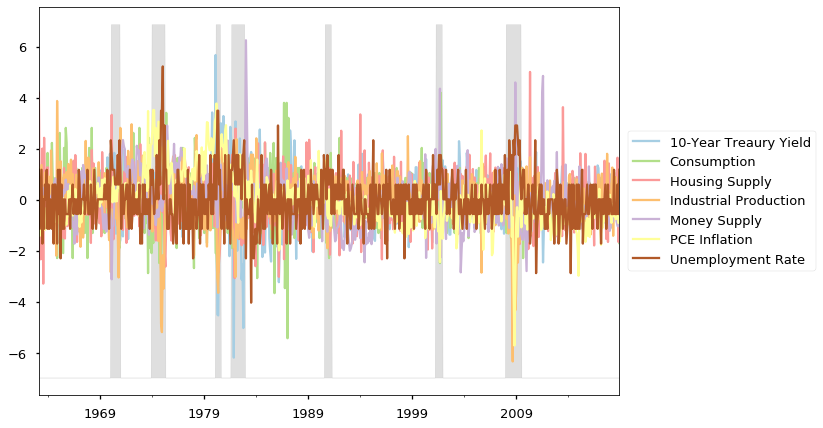

In [45]:
data_fig, data_ax = mpl.pyplot.subplots(1,1)
data.plot(ax=data_ax, colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = data_ax.get_ylim()
data_ax.fill_between(x=recessions.index, y1=recessions.apply(
            lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
data_ax.set_xlabel("")

data_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

data_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_data_series{mode}.pdf', 
                 transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

## Results

In [46]:
percentiles = [1,5, 25, 50, 75, 95, 99]

In [47]:
if forecast_type == 'cdpm':
    state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)
    trans_mat_mean = pd.DataFrame(normalize(np.mean(np.nan_to_num(trans_mat_draws), axis=0),norm='l1'))
    print(trans_mat_mean.iloc[:5, :5])

          0         1         2         3         4
0  0.993137  0.003292  0.002552  0.000755  0.000264
1  0.569153  0.170346  0.197860  0.048325  0.014316
2  0.459845  0.244910  0.221371  0.060457  0.013417
3  0.395793  0.164068  0.197124  0.193294  0.049722
4  0.332181  0.191002  0.160534  0.134612  0.181671


In [48]:
if forecast_type == 'cdpm':
    stationary_dist = cdpm.compute_stationary_distribution(trans_mat_draws, progress_bar=tqdm_notebook)
    print(stationary_dist.mean().cumsum().head())



0    0.992716
1    0.995490
2    0.998451
3    0.999399
4    0.999788
dtype: float64


## Parameter estimates

In [17]:
comp_cov_mean = np.nanmean(comp_cov_draws, axis=0) 

if forecast_type == 'cdpm':

    for idx, arr in enumerate(comp_cov_mean[:3]):
        df_to_print = pd.DataFrame(arr, columns=data.columns, index=data.columns).T
        print(f"Comp {idx}:\n\n {df_to_print}\n")
else:
    df_to_print = pd.DataFrame(comp_cov_mean, columns=data.columns, index=data.columns).T
    print(df_to_print)   

Comp 0:

                        10-Year Treaury Yield  Consumption  Housing Supply  \
10-Year Treaury Yield               0.893488     0.029563        0.031517   
Consumption                         0.029563     1.019818       -0.067727   
Housing Supply                      0.031517    -0.067727        0.837456   
Industrial Production               0.087343     0.261890        0.041444   
Money Supply                       -0.031728    -0.013282       -0.041103   
PCE Inflation                       0.052232    -0.042261       -0.000377   
Unemployment Rate                  -0.101414    -0.109726       -0.055552   

                       Industrial Production  Money Supply  PCE Inflation  \
10-Year Treaury Yield               0.087343     -0.031728       0.052232   
Consumption                         0.261890     -0.013282      -0.042261   
Housing Supply                      0.041444     -0.041103      -0.000377   
Industrial Production               0.838745      0.028340      -

In [18]:
if 'cov_mean' in results:
    df_to_print = pd.DataFrame(np.mean(np.nanmean(cov_mean_draws, axis=0), axis=0), columns=data.columns,
                               index=data.columns)
    print(df_to_print)   

                       10-Year Treaury Yield  Consumption  Housing Supply  \
10-Year Treaury Yield               2.379583     0.062306        0.058251   
Consumption                         0.062306     2.642215       -0.152999   
Housing Supply                      0.058251    -0.152999        2.267645   
Industrial Production               0.177562     0.562485        0.081556   
Money Supply                       -0.009211    -0.006511       -0.010902   
PCE Inflation                       0.021009    -0.012821       -0.004699   
Unemployment Rate                  -0.224751    -0.203841       -0.126074   

                       Industrial Production  Money Supply  PCE Inflation  \
10-Year Treaury Yield               0.177562     -0.009211       0.021009   
Consumption                         0.562485     -0.006511      -0.012821   
Housing Supply                      0.081556     -0.010902      -0.004699   
Industrial Production               2.216345      0.008325      -0.005148  

In [19]:
comp_coeff_mean = np.nanmean(beta_draws, axis=0) 

if forecast_type == 'cdpm':

    for idx, arr in enumerate(comp_coeff_mean[:3]):
        df_to_print = pd.DataFrame(arr, columns=data.columns, index=regressor.columns).T
        print(f"Comp {idx}:\n\n {df_to_print}\n")
else:
    df_to_print = pd.DataFrame(comp_coeff_mean, columns=data.columns, index=regressor.columns).T
    print(df_to_print)   

Comp 0:

                        Intercept  10-Year Treaury Yield  Consumption  \
10-Year Treaury Yield  -0.000830               0.272325     0.123864   
Consumption             0.002328              -0.035741    -0.222874   
Housing Supply         -0.006152               0.271053    -0.043955   
Industrial Production  -0.002513               0.122386     0.068523   
Money Supply           -0.001275              -0.159759     0.103681   
PCE Inflation           0.000799               0.049586     0.091005   
Unemployment Rate      -0.001517              -0.075418    -0.114866   

                       Housing Supply  Industrial Production  Money Supply  \
10-Year Treaury Yield       -0.090931               0.000579      0.064221   
Consumption                 -0.021551               0.135850      0.134370   
Housing Supply              -0.254753               0.059567     -0.012202   
Industrial Production        0.009017               0.195321      0.010978   
Money Supply           

In [20]:
if 'beta_mean' in results:
    df_to_print2 = pd.DataFrame(np.nanmean(beta_mean_draws, axis=0), columns=data.columns,
                               index=regressor.columns).T
    print(df_to_print2)   

                       Intercept  10-Year Treaury Yield  Consumption  \
10-Year Treaury Yield   0.000147               0.136771     0.061998   
Consumption             0.002153              -0.021616    -0.123153   
Housing Supply         -0.004410               0.138793    -0.031281   
Industrial Production  -0.002304               0.058320     0.043444   
Money Supply           -0.000754              -0.092262     0.059967   
PCE Inflation           0.002325               0.027635     0.060178   
Unemployment Rate       0.001195              -0.029064    -0.066428   

                       Housing Supply  Industrial Production  Money Supply  \
10-Year Treaury Yield       -0.045870              -0.013798      0.028494   
Consumption                 -0.016421               0.052670      0.067508   
Housing Supply              -0.139901               0.026268     -0.011101   
Industrial Production        0.013034               0.079376      0.003066   
Money Supply                -0.03

In [21]:
if 'cluster_identity' in results:
    mean_est, var_from_mean, innov_var  = cdpm.compute_mean_and_var(regressor, regressand,
                                                                trans_mat_draws[-num_forecast_draws:],
                                                                cluster_identity_draws.iloc[-num_forecast_draws:],
                                                                beta_draws[-num_forecast_draws:], 
                                                                comp_cov_draws[-num_forecast_draws:],
                                                                progress_bar=tqdm_notebook)
else:
    mean_est = pd.DataFrame(regressor @ comp_coeff_mean).shift(-1).dropna()
    mean_est.columns = regressand.columns
    var_from_mean = pd.DataFrame(np.zeros(mean_est.shape), index=mean_est.index, columns=mean_est.columns)
    innov_var = pd.DataFrame(np.tile(np.diag(comp_cov_mean), (mean_est.index.shape[0], 1)),
                            index=mean_est.index, columns=mean_est.columns)

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


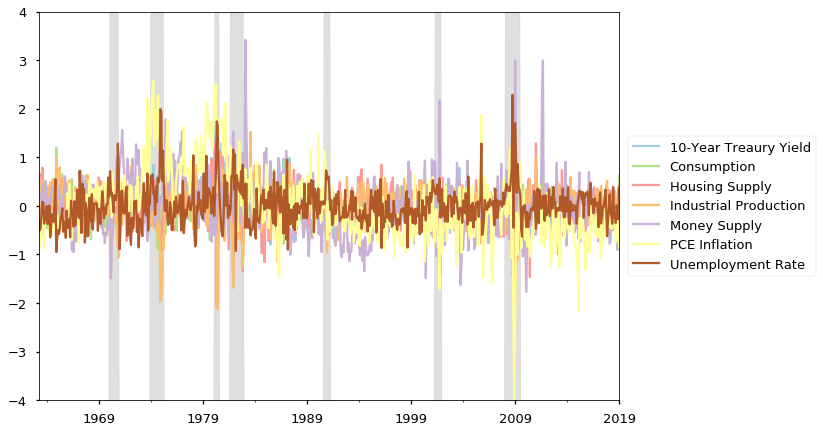

In [22]:
mean_fig, mean_ax = mpl.pyplot.subplots(1,1)
mean_est.plot(ax=mean_ax, colormap=mpl.cm.get_cmap('Paired'))
mean_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
mean_ax.set_ylim(-4,4)
lower_y, upper_y = mean_ax.get_ylim()

mean_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
mean_ax.set_xlabel("")

mean_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_mean_forecast{mode}.pdf',
                 transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


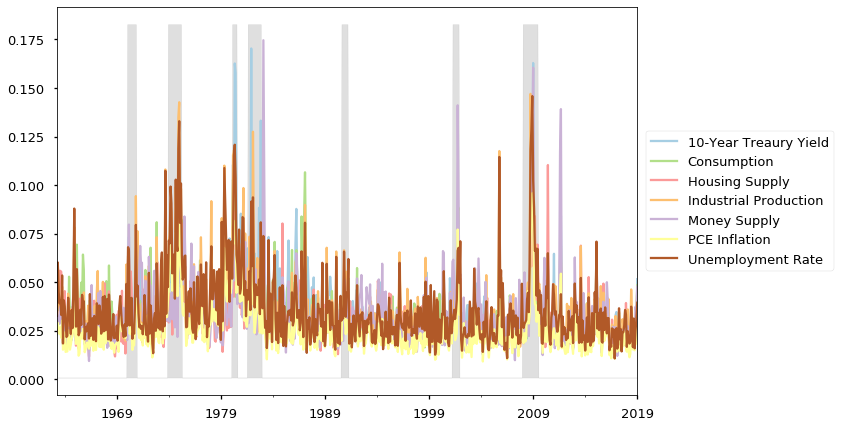

In [23]:
std_from_mean_fig, std_from_mean_ax = mpl.pyplot.subplots(1,1)
var_from_mean.apply(np.sqrt).sort_index(axis=1).plot(ax=std_from_mean_ax, colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = std_from_mean_ax.get_ylim()
std_from_mean_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
std_from_mean_ax.set_xlabel("")
std_from_mean_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

std_from_mean_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_std_from_mean{mode}.pdf', 
                          transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  del sys.path[0]


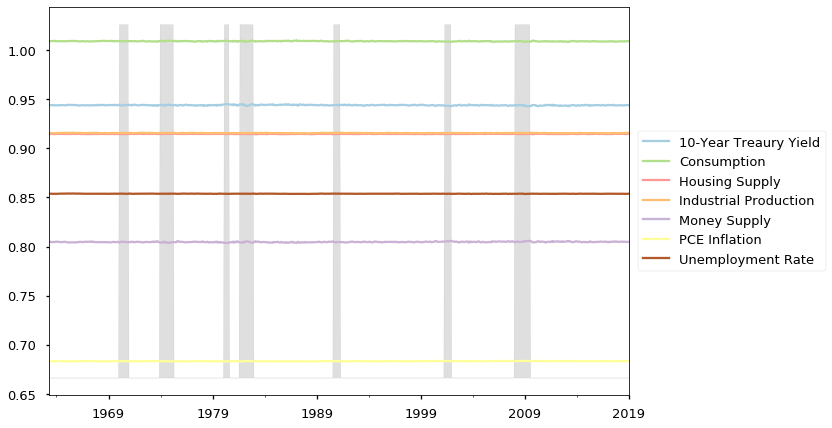

In [24]:
std_from_var_fig, std_from_var_ax = mpl.pyplot.subplots(1,1)

innov_var.apply(np.sqrt).sort_index(axis=1).plot(
    ax=std_from_var_ax, colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = std_from_var_ax.get_ylim()
std_from_var_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
std_from_var_ax.set_xlabel("")
std_from_var_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

std_from_var_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_std_from_var{mode}.pdf',
                         transparent=True,frameon=False, bbox_inches='tight', pad_inches=0)

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  del sys.path[0]


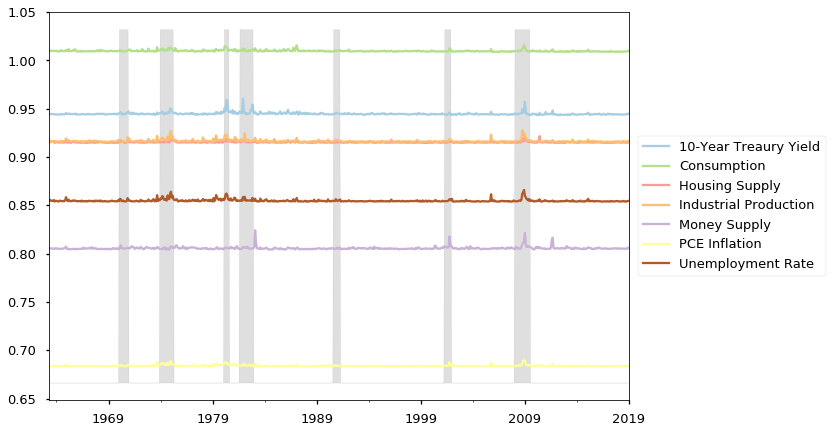

In [25]:
std_total_fig, std_total_ax = mpl.pyplot.subplots(1,1)

(innov_var + var_from_mean).apply(np.sqrt).sort_index(axis=1).plot(ax=std_total_ax,
                                                                   colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = std_total_ax.get_ylim()
std_total_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
std_total_ax.set_xlabel("")
std_total_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

std_total_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_std_total{mode}.pdf',
                      transparent=True,frameon=False, bbox_inches='tight', pad_inches=0)

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


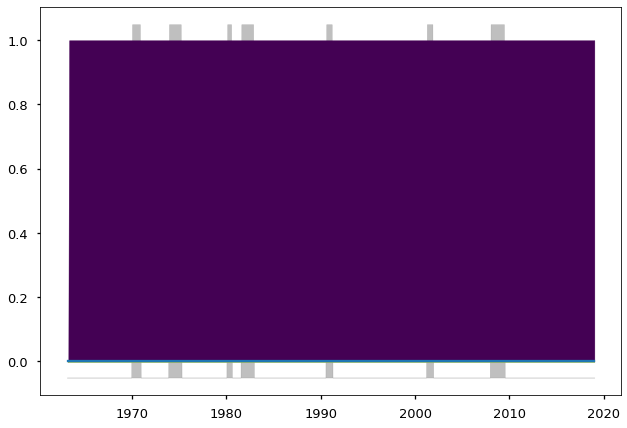

In [26]:
if 'cluster_identity' in results:
    cluster_id_fig, cluster_id_ax = mpl.pyplot.subplots(1,1)
    cdpm.fan_plot(data=pd.DataFrame(cluster_identity_draws.T, index=data.index[1:]), ax=cluster_id_ax, 
                  percentiles=percentiles)

    lower_y, upper_y = cluster_id_ax.get_ylim()
    cluster_id_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    cluster_id_ax.set_xlabel("")


    cluster_id_fig.savefig(f'../doc/density_figures/{forecast_type}/{forecast_type}_cluster_id{mode}.pdf',
                       transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

In [27]:
if forecast_type == 'cdpm':
    posterior_cluster_probs = pd.DataFrame(np.column_stack([np.mean(cluster_identity_draws == idx, axis=0) 
                           for idx in np.unique(cluster_identity_draws)]), index=data.index[1:])

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


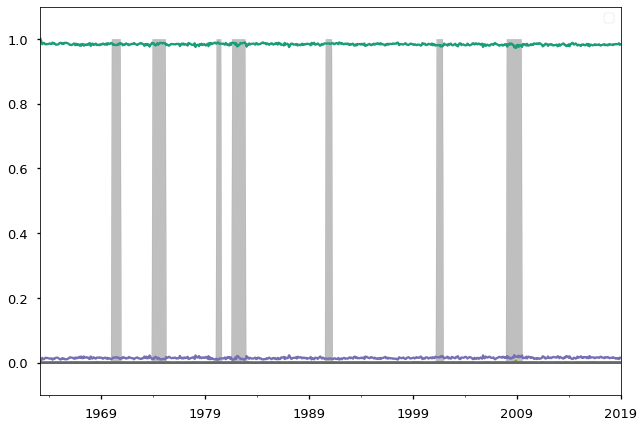

In [28]:
if 'cluster_identity' in results:
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    posterior_cluster_probs.plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([-.1,1.1])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
    cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    cluster_probs_fig.savefig(f'../doc/density_figures/cdpm/{filename_id}_cluster_probs{mode}.pdf',
                              transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


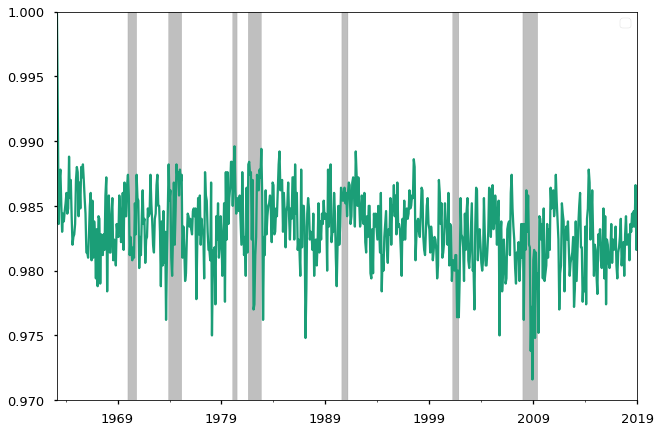

In [29]:
if forecast_type == 'cdpm':
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    posterior_cluster_probs[0].plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([0.97,1.0])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
    cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    cluster_probs_fig.savefig(f'../doc/density_figures/cdpm/{filename_id}_1stcluster_probs{mode}.pdf',
                              transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)
    

In [30]:
if forecast_type == 'cdpm':
    remaining_cluster_probs = posterior_cluster_probs[1]+posterior_cluster_probs[2]+posterior_cluster_probs[3]+posterior_cluster_probs[4]

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


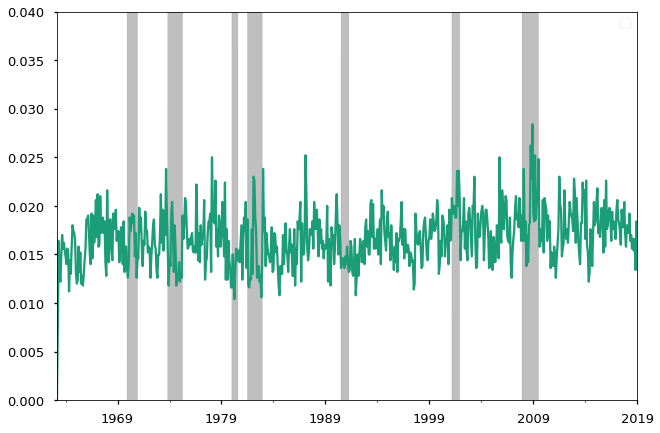

In [31]:
if forecast_type == 'cdpm':
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    #posterior_cluster_probs[1].plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    remaining_cluster_probs.plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([0.0,0.04])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
    cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    cluster_probs_fig.savefig(f'../doc/density_figures/cdpm/{filename_id}_2ndcluster_probs{mode}.pdf',
                              transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

    

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


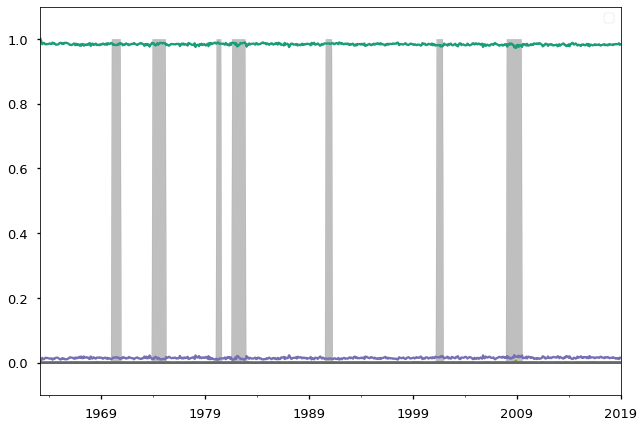

In [32]:
if 'cluster_identity' in results:
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    posterior_cluster_probs.plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([-.1,1.1])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
    cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    cluster_probs_fig.savefig(f'../doc/density_figures/cdpm/{filename_id}_cluster_probs{mode}.pdf',
                              transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

## Forecasting

In [33]:
if forecast_type == 'cdpm':
    data_est_mat = cdpm.forecast_draws(cluster_identity_draws, trans_mat_draws, beta_draws,comp_cov_draws,
                                   regressor, progress_bar=tqdm_notebook)
elif forecast_type == 'VAR':
        data_est_mat = np.swapaxes(cdpm.forecast_var(beta_draws=beta_draws,comp_cov_draws=comp_cov_draws,
                                         regressor=regressor,progress_bar=tqdm_notebook), 1, 0)

AttributeError: module 'cdpm' has no attribute 'forecast_draws'

In [ ]:
univariate_forecast = pd.DataFrame(
    np.squeeze(data_est_mat[:,:, np.nonzero(regressand.columns == univariate_name)]),
             index=data.index[2:])

In [ ]:
list(combinations(data.columns, 2))

In [ ]:
if forecast_type == 'cdpm':

    correlation_series = []
    for name1, name2 in tqdm_notebook(list(combinations(data.columns, 2))):
    
        series1 = pd.DataFrame(
            np.squeeze(data_est_mat[:, np.nonzero(regressand.columns == name1), :]), index=data.index[2:])
        series2 = pd.DataFrame(
            np.squeeze(data_est_mat[:, np.nonzero(regressand.columns == name2), :]), index=data.index[2:])
    
        covariance = ((series1.transform(lambda x: x - np.mean(x), axis=1) 
                      * series2.agg(lambda x: x - np.mean(x), axis=1)).apply(np.mean, axis=1)) 
    
        correlation = (covariance / np.sqrt(np.var(series1, axis=1) * np.var(series2, axis=1))).to_frame()
        correlation.columns = [name1 + " , " + name2]
        
        correlation_series.append(correlation)
        
    correlations_df = pd.concat(correlation_series, axis=1)   

In [154]:
correlations_df.describe()

10-Year Treaury Yield,Consumption  \
count                         669.000000   
mean                            0.030448   
std                             0.014318   
min                            -0.011104   
25%                             0.020513   
50%                             0.030442   
75%                             0.040291   
max                             0.073999   

       10-Year Treaury Yield,Housing Supply  \
count                            669.000000   
mean                               0.040813   
std                                0.014591   
min                               -0.012073   
25%                                0.030677   
50%                                0.042091   
75%                                0.051293   
max                                0.078369   

       10-Year Treaury Yield,Industrial Production  \
count                                   669.000000   
mean                                      0.101340   
std                                       0.013326   
min                                       0.058115   
25%                                       0.092389   
50%                                       0.101195   
75%                                       0.110571   
max                                       0.148482   

       10-Year Treaury Yield,Money Supply  \
count                          669.000000   
mean                            -0.043003   
std                              0.014378   
min                             -0.080736   
25%                             -0.053187   
50%                             -0.043271   
75%                             -0.032997   
max                              0.000580   

       10-Year Treaury Yield,PCE Inflation  \
count                           669.000000   
mean                              0.079019   
std                               0.013809   
min                               0.041122   
25%                               0.069698   
50%                               0.078680   
75%                               0.088549   
max                               0.123680   

       10-Year Treaury Yield,Unemployment Rate  Consumption,Housing Supply  \
count                               669.000000                  669.000000   
mean                                 -0.124835                   -0.063282   
std                                   0.014461                    0.014250   
min                                  -0.170995                   -0.103882   
25%                                  -0.133860                   -0.072604   
50%                                  -0.124261                   -0.063190   
75%                                  -0.115551                   -0.053656   
max                                  -0.078562                   -0.015287   

       Consumption,Industrial Production  Consumption,Money Supply  \
count                         669.000000                669.000000   
mean                            0.281507                 -0.018306   
std                             0.012559                  0.014113   
min                             0.243288                 -0.058350   
25%                             0.272726                 -0.027492   
50%                             0.281449                 -0.017658   
75%                             0.289879                 -0.008864   
max                             0.316941                  0.034244   

       Consumption,PCE Inflation  ...  Housing Supply,Industrial Production  \
count                 669.000000  ...                            669.000000   
mean                   -0.062100  ...                              0.050961   
std                     0.013849  ...                              0.014237   
min                    -0.105390  ...                             -0.004293   
25%                    -0.071469  ...                              0.041879   
50%                    -0.061988  ...                              0.0

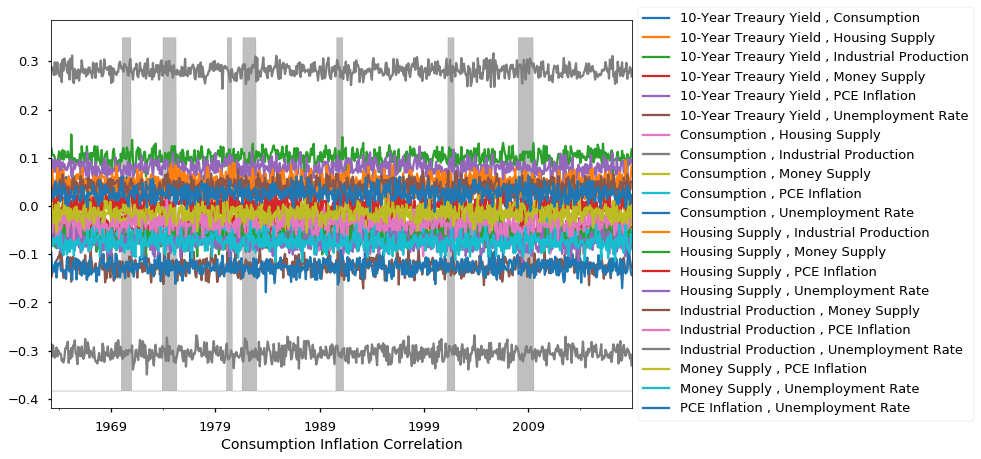

In [166]:
if forecast_type == 'cdpm':
    corr1_fig, corr1_ax = mpl.pyplot.subplots()
    correlations_df.plot(ax=corr1_ax)

    lower_y, upper_y = corr1_ax.get_ylim()
    corr1_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    corr1_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    corr1_ax.set_xlabel("Consumption Inflation Correlation")
    corr1_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_time_varying_corr{mode}.pdf'.replace(" ", "_"),
                         transparent=True,frameon=False, bbox_inches='tight', pad_inches=0)

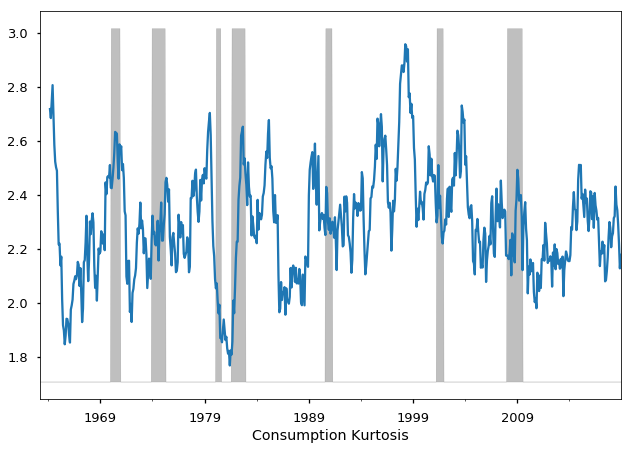

In [37]:
kurt_fig, kurt_ax = mpl.pyplot.subplots()
univariate_forecast.dropna(axis=1).agg(stats.kurtosis, fisher=False, axis=1).rolling(window=12).mean().plot(ax=kurt_ax)

lower_y, upper_y = kurt_ax.get_ylim()
kurt_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
kurt_ax.set_xlabel(f"{univariate_name} Kurtosis")
kurt_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_{univariate_name}_kurt{mode}.pdf'.replace(" ", "_"),
                         transparent=True,frameon=False, bbox_inches='tight', pad_inches=0)

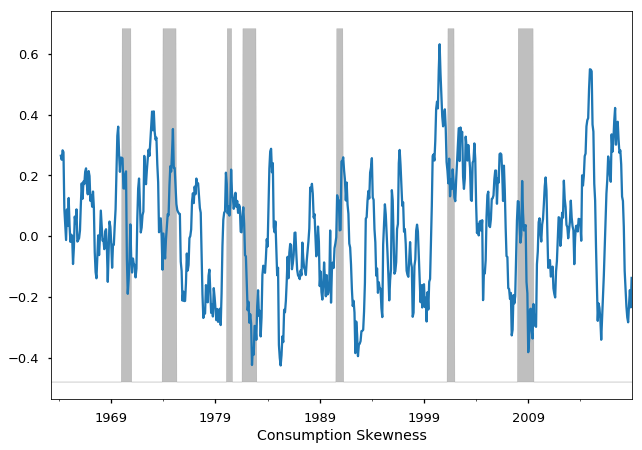

In [38]:
skew_fig, skew_ax = mpl.pyplot.subplots()
univariate_forecast.dropna(axis=1).agg(stats.skew, axis=1).rolling(window=12).mean().plot(ax=skew_ax)

lower_y, upper_y = skew_ax.get_ylim()
skew_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
skew_ax.set_xlabel(f"{univariate_name} Skewness")
skew_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_{univariate_name}_skew{mode}.pdf'.replace(" ", "_"),
                         transparent=True,frameon=False, bbox_inches='tight', pad_inches=0)

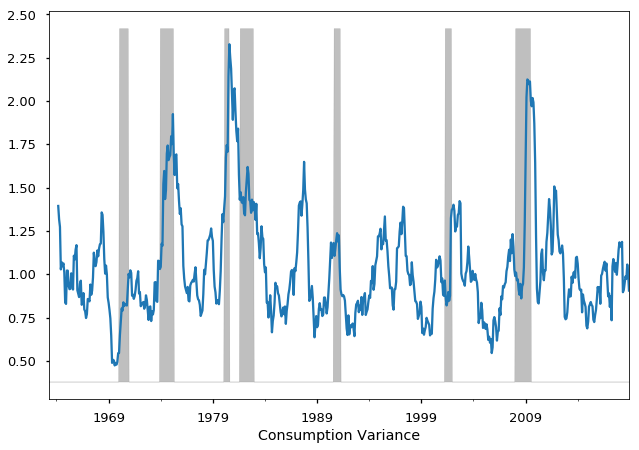

In [39]:
consump_var_fig, consump_var_ax = mpl.pyplot.subplots()
univariate_forecast.agg(np.var, axis=1).rolling(window=12).mean().plot(ax=consump_var_ax)

lower_y, upper_y = consump_var_ax.get_ylim()
consump_var_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
consump_var_ax.set_xlabel(f"{univariate_name} Variance")
consump_var_fig.savefig(f'../doc/density_figures/{forecast_type}/{filename_id}_{univariate_name}_var{mode}.pdf'.replace(" ", "_"),
                        transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

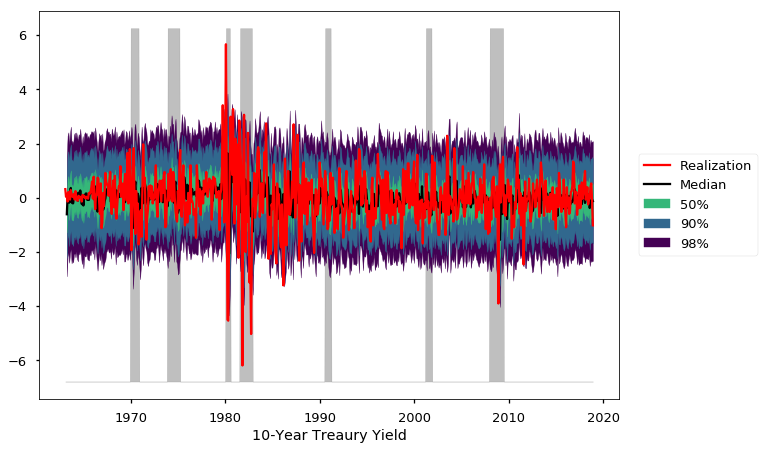

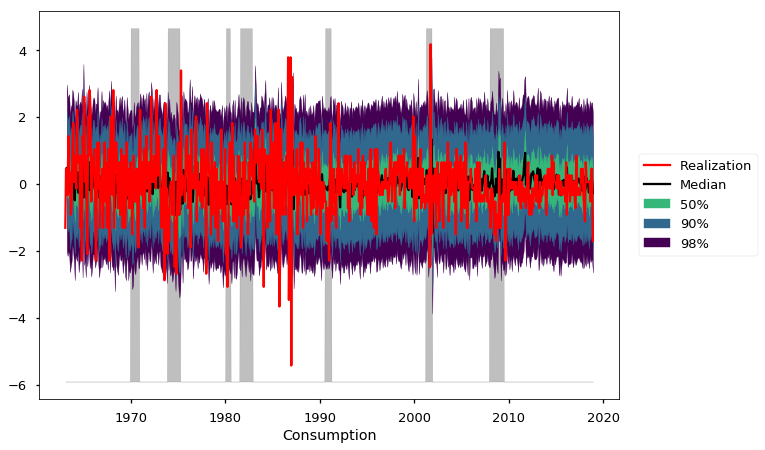

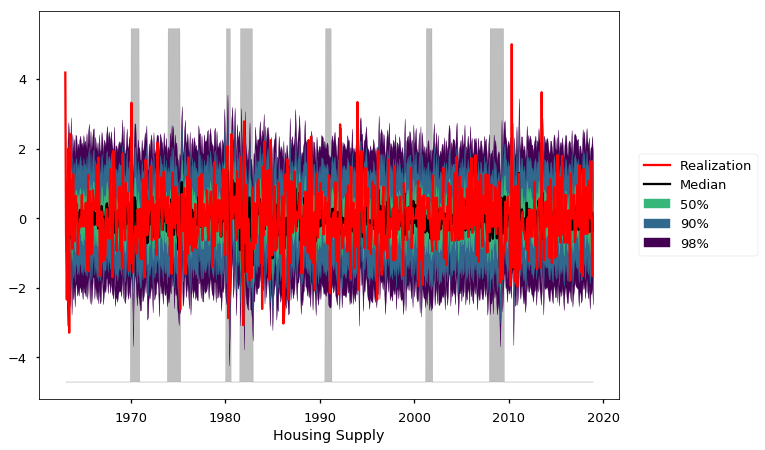

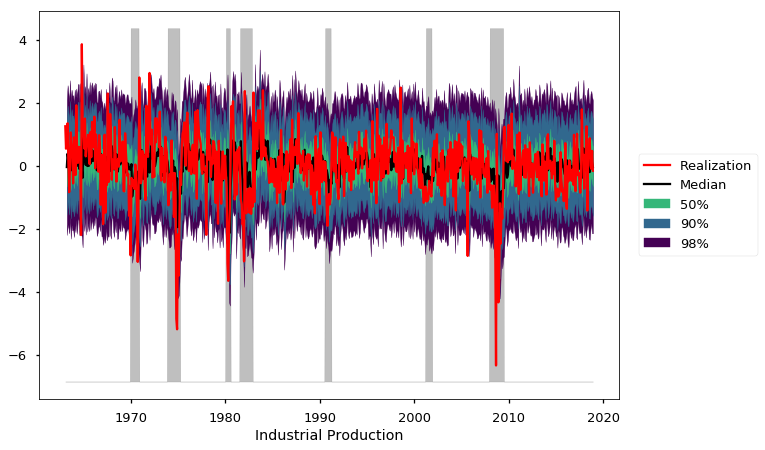

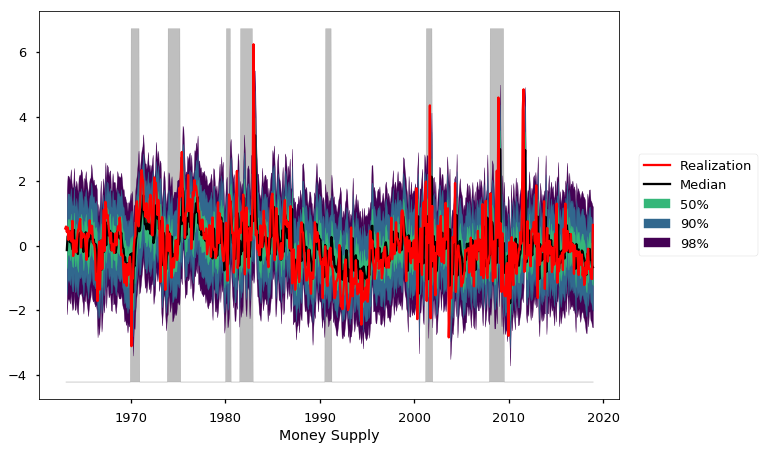

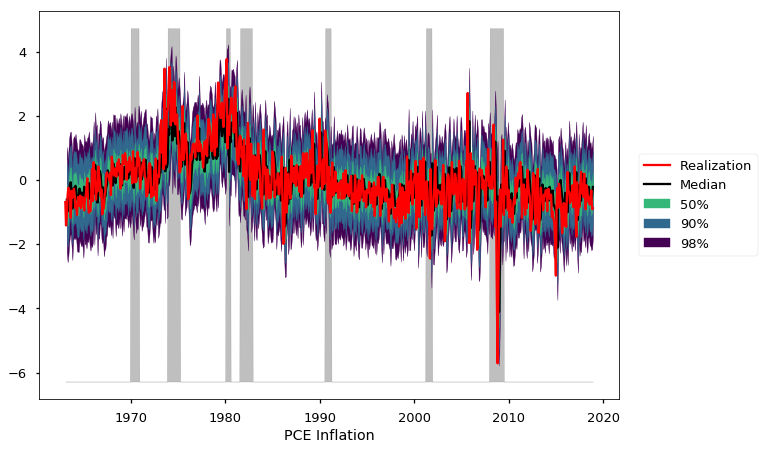

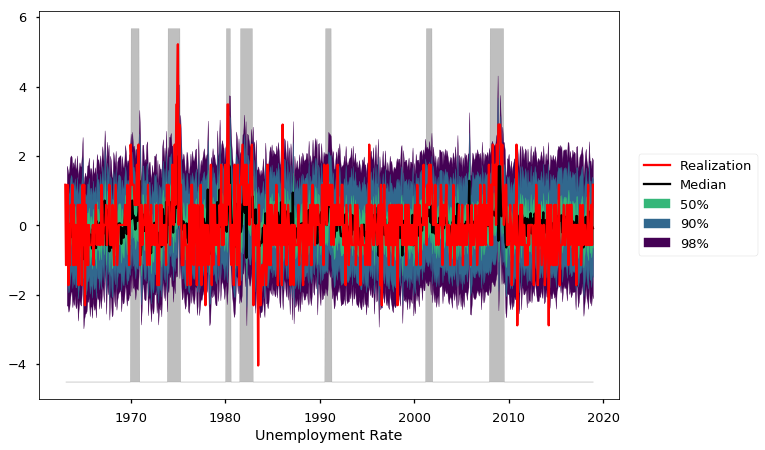

In [40]:
for idx, val in enumerate(regressand.columns):
    data_comparison_fig, data_comparison_ax = mpl.pyplot.subplots(1,1)
    data_comparison_ax.plot(data.index, data[val].values, color='red', label='Realization', zorder=10)
    cdpm.fan_plot(data=pd.DataFrame(np.squeeze(data_est_mat[:,idx,:]), index=data.index[2:]), 
                  ax=data_comparison_ax, percentiles=percentiles, color='black', 
                  labels=['Median'] + ['98%', '90%','50%'])

    data_comparison_ax.set_xlabel(val)
    lower_y, upper_y = data_comparison_ax.get_ylim()
    data_comparison_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    data_comparison_ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    
    filename_4_forecast = f'../doc/density_figures/{forecast_type}/{val}_{filename_id}_forecasts{mode}.pdf'.replace(" ", "_")
    data_comparison_fig.savefig(filename_4_forecast, transparent=True, frameone=False, bbox_inches='tight',
                                pad_inches=0)

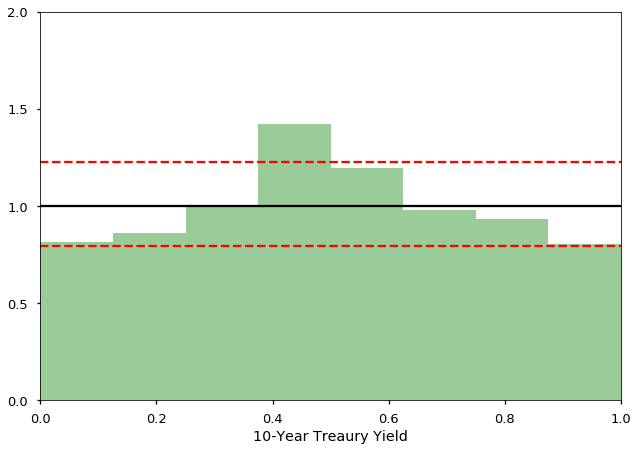

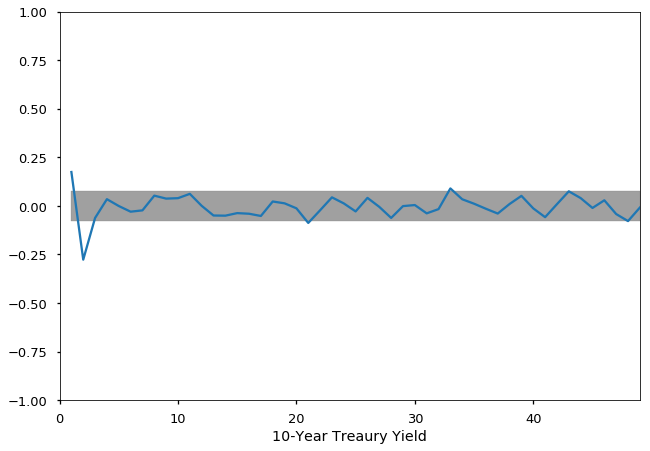

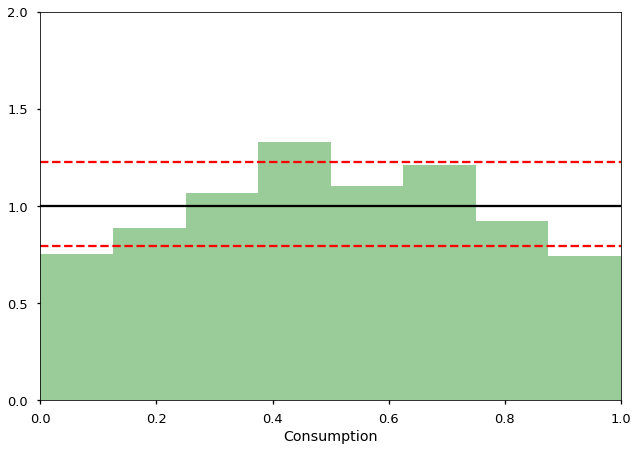

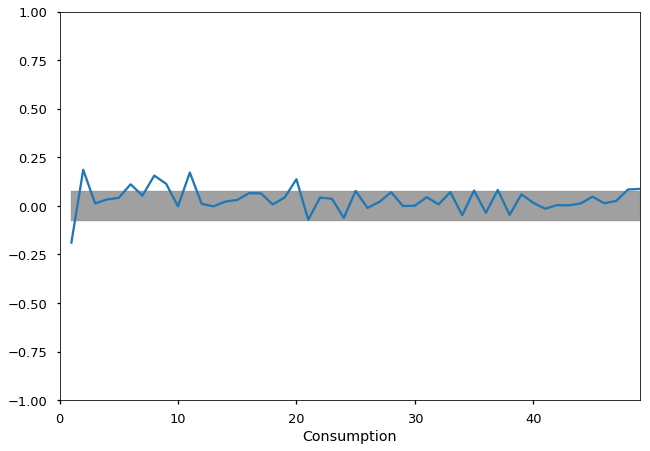

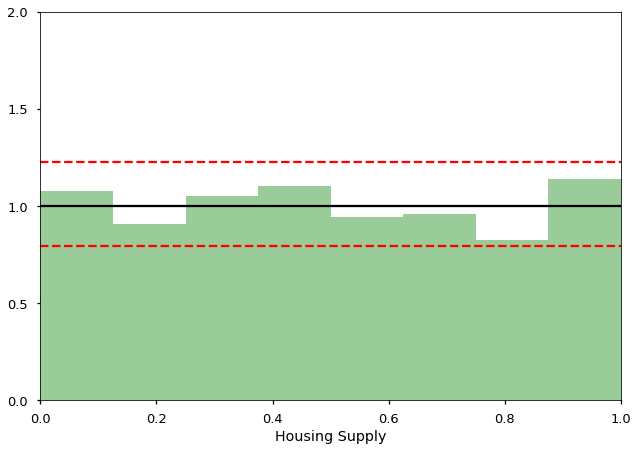

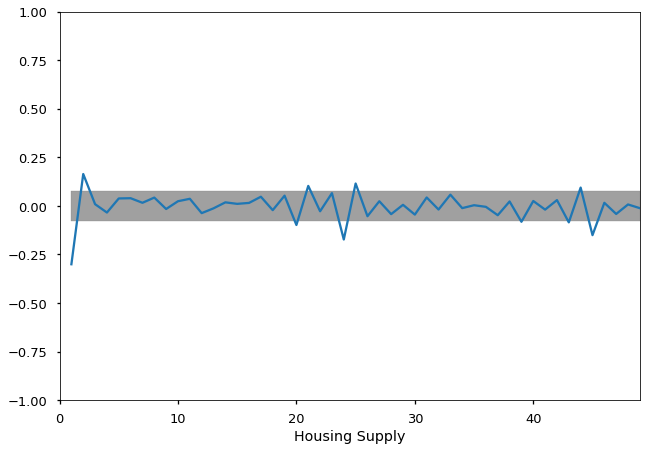

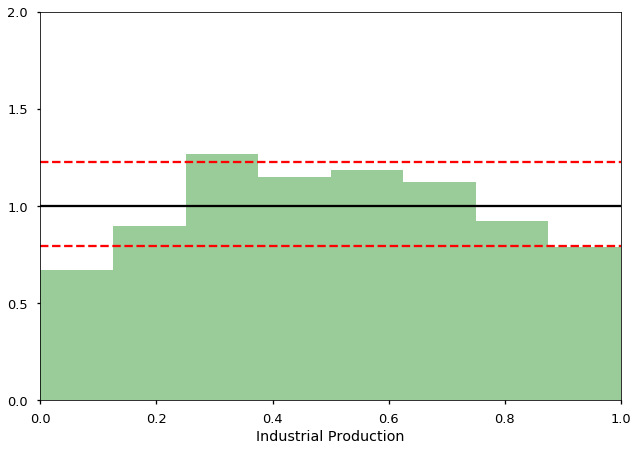

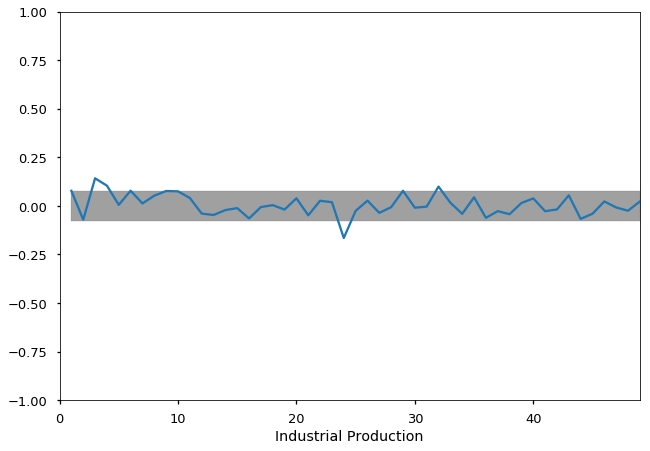

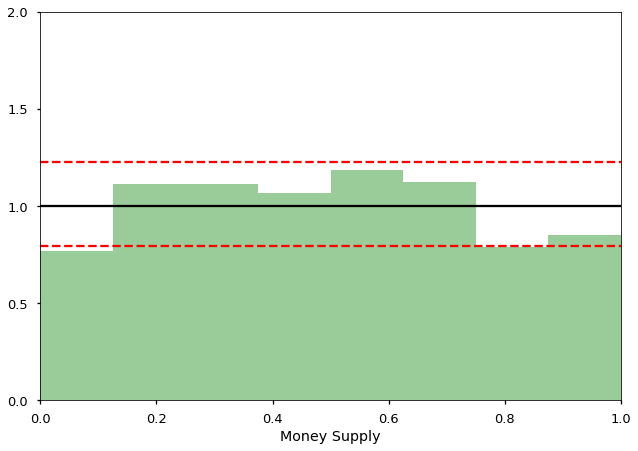

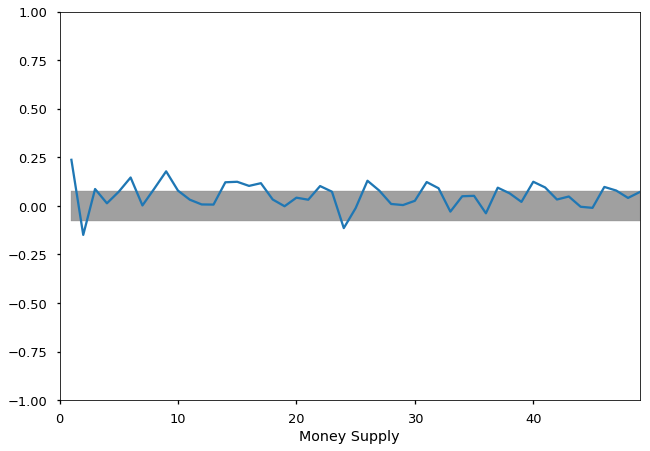

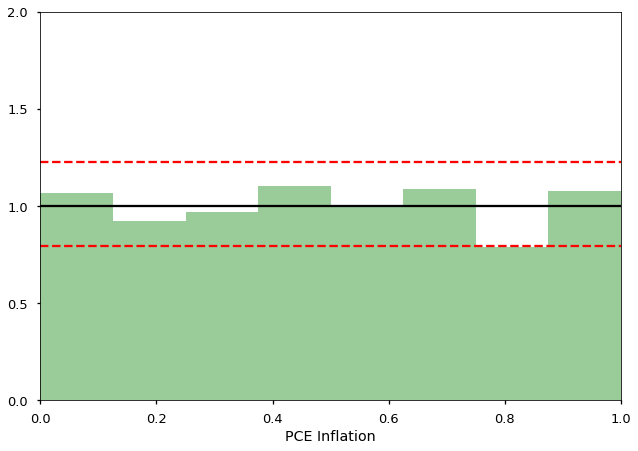

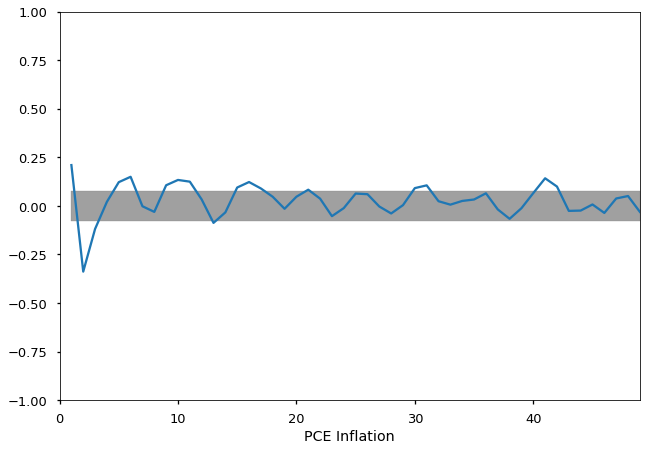

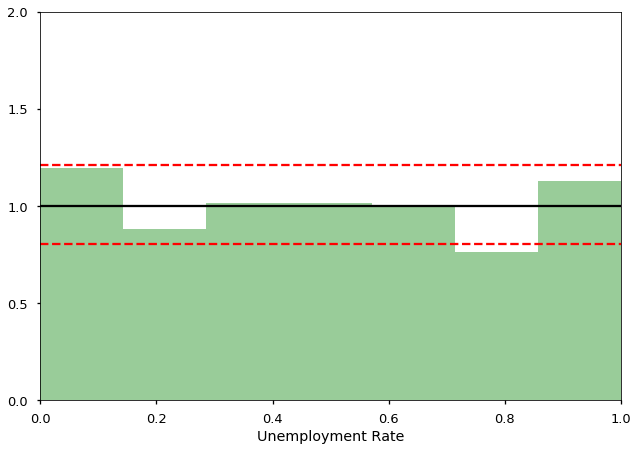

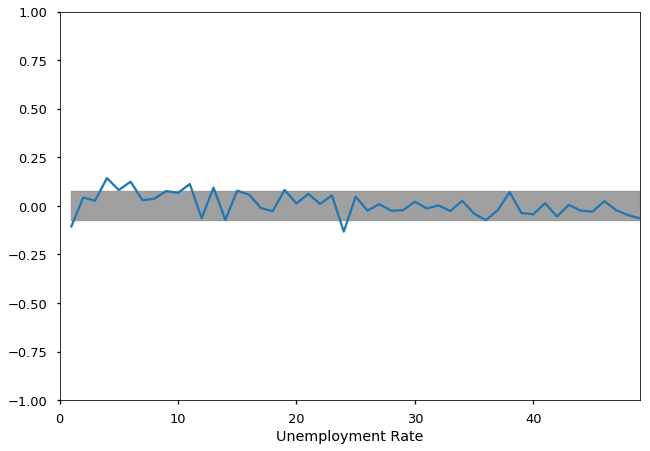

In [41]:
for idx, val in enumerate(regressand.columns):
    estimates = pd.DataFrame(np.squeeze(data_est_mat[:,idx,:]), index=data.index[2:])
    pit = cdpm.probability_integral_transform(estimates, data[val].iloc[2:])
    pit_fig, pit_ax = mpl.pyplot.subplots()
    cdpm.pit_plot(pit, ax=pit_ax, pct=.95, color='green')
    pit_ax.set_xlabel(val)
    pit_fig.savefig(f'../doc/density_figures/{forecast_type}/{val}_{filename_id}_pit{mode}.pdf'.replace(" ", "_"),
                    bbox_inches='tight', pad_inches=0, transparent=True, frameon=False)
    
    acf_fig, acf_ax = mpl.pyplot.subplots()
    acf_ax.set_xlabel(val)
    cdpm.pit_acf_plot(pit, ax=acf_ax, color='grey', alpha=.75)
    acf_fig.savefig(f'../doc/density_figures/{forecast_type}/{val}_{filename_id}_acf{mode}.pdf'.replace(" ", "_"),
                    bbox_inches='tight', pad_inches=0, transparent=True, frameon=False)